In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/AI Course - 2024/3 - Machine Learning/Decision Trees/Personal Loan Campaign

/content/drive/MyDrive/AI Course - 2024/3 - Machine Learning/Decision Trees/Personal Loan Campaign


In [ ]:
!apt-get install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive is already the newest version (2021.20220204-1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!mkdir -p images_no_outliers

In [ ]:
remove_outliers = False
to_stratify = False

In [ ]:
if remove_outliers:
  image_path = 'images_no_outliers'
  datafilename = 'Loan_Modeling_clean_no_outliers.csv'
else:
  image_path = 'images'
  datafilename = 'Loan_Modeling_clean.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

import math

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt



# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

# Library to split data
from sklearn.model_selection import train_test_split

# Libraries to build decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

# To perform statistical analysis
import scipy.stats as stats

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    auc,
    make_scorer,
)


# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings("ignore")

In [ ]:
scoring_methods = ['F1', 'Recall','Precision', 'Accuracy']

In [ ]:

# dtype = {
#  'CD_Account': 'category',
#  'CreditCard': 'category',
#  'Education': 'category',
#  'Family': 'category',
#  'Online': 'category',
#  'Personal_Loan': 'category',
#  'Securities_Account': 'category',
#  'ZIPCode (SCF)': 'category'}

dtype = {'ZIPCode (SCF)': str}


df = pd.read_csv(datafilename, dtype=dtype)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   CCAvg               5000 non-null   float64
 2   CD_Account          5000 non-null   int64  
 3   CreditCard          5000 non-null   int64  
 4   Education           5000 non-null   int64  
 5   Experience          5000 non-null   int64  
 6   Family              5000 non-null   int64  
 7   Income              5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Mortgage > 0        1538 non-null   float64
 10  Online              5000 non-null   int64  
 11  Personal_Loan       5000 non-null   int64  
 12  Securities_Account  5000 non-null   int64  
 13  ZIPCode (SCF)       5000 non-null   object 
dtypes: float64(2), int64(11), object(1)
memory usage: 547.0+ KB


In [ ]:
df.head()

,Age,CCAvg,CD_Account,CreditCard,Education,Experience,Family,Income,Mortgage,Mortgage > 0,Online,Personal_Loan,Securities_Account,ZIPCode (SCF)
0,25,1.6,0,0,1,1,4,49,0,NaN,0,0,1,91
1,45,1.5,0,0,1,19,3,34,0,NaN,0,0,1,90
2,39,1.0,0,0,1,15,1,11,0,NaN,0,0,0,94
3,35,2.7,0,0,2,9,1,100,0,NaN,0,0,0,94
4,35,1.0,0,1,2,8,4,45,0,NaN,0,0,0,91


In [ ]:
def correlation_numeric_analysis(corr):
  upper_triangle_indices = np.triu_indices_from(corr, k=1)
  corr_pairs = [
      (corr.index[i], corr.columns[j], corr.iloc[i, j])
      for i, j in zip(*upper_triangle_indices)
  ]

  # Convert to DataFrame for sorting
  corr_pairs_df = pd.DataFrame(corr_pairs, columns=["Variable 1", "Variable 2", "Correlation"])

  # Sort the pairs by correlation value
  sorted_corr_pairs = corr_pairs_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

  return sorted_corr_pairs


def heatmap(matrix,figsize=(15, 7), vmin = -1 , vmax = 1, corner = True,
            rotation_x = 45, rotation_y = 45, annot=True, to_rename = True,
            tick_fontsize = None,
            name=''):

  if to_rename:
    matrix_columns = matrix.columns.tolist()
    matrix_index = matrix.index.tolist()

    rename_var = lambda x: x.replace('_', '\n')

    matrix.columns = list(map(rename_var, matrix_columns))
    matrix.index = list(map(rename_var, matrix_index))


  mask = None
  plt.figure(figsize = figsize)

  shrink = 1

  corner_or_square = 'corner' if corner else 'square'

  if corner:
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    matrix_rm_diag = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(bool))


    round_num_up = lambda x: -math.floor(abs(x) * 10) / (10) if x<0 else math.ceil(x * 10) / (10)
    round_num_down = lambda x: -math.ceil(abs(x) * 10) / (10) if x<0 else math.floor(x * 10) / (10)
    min_value = matrix_rm_diag.min().min()
    max_value = matrix_rm_diag.max().max()

    vmin = round_num_down(min_value)
    vmax = round_num_up(max_value)

    max_abs = max(abs(vmin), abs(vmax))
    vmin = -max_abs
    vmax = max_abs

  if corner:
    shrink = (matrix.shape[0]-2)/matrix.shape[0]


  ax = sns.heatmap(matrix, mask=mask, annot=annot, vmin=vmin, vmax=vmax, fmt=".2f",
              cbar_kws={"shrink": shrink, 'pad': 0},
              linewidth=2,
              square = True,
              cmap="coolwarm")

  ax.set(xlabel="", ylabel="")
  # ax.xaxis.tick_top()
  if tick_fontsize:
    ax.tick_params(axis='both', labelsize=tick_fontsize)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation_x, ha='right')
  ax.set_yticklabels(ax.get_yticklabels(), rotation=rotation_y)

  plt.tick_params(left=False, bottom=False)


  plt.savefig(f"{image_path}/heatmap_{name}_{corner_or_square}.png", bbox_inches='tight');


,Variable 1,Variable 2,Correlation
0,Age,Experience,0.993991
1,CCAvg,Income,0.645984
2,Income,Personal_Loan,0.502462
3,CCAvg,Personal_Loan,0.366889
4,CD_Account,Securities_Account,0.317034
5,CD_Account,Personal_Loan,0.316355
6,CD_Account,CreditCard,0.278644
7,Income,Mortgage,0.206806
149,ZIPCode (SCF)_92,ZIPCode (SCF)_95,-0.218992
150,ZIPCode (SCF)_91,ZIPCode (SCF)_94,-0.230551


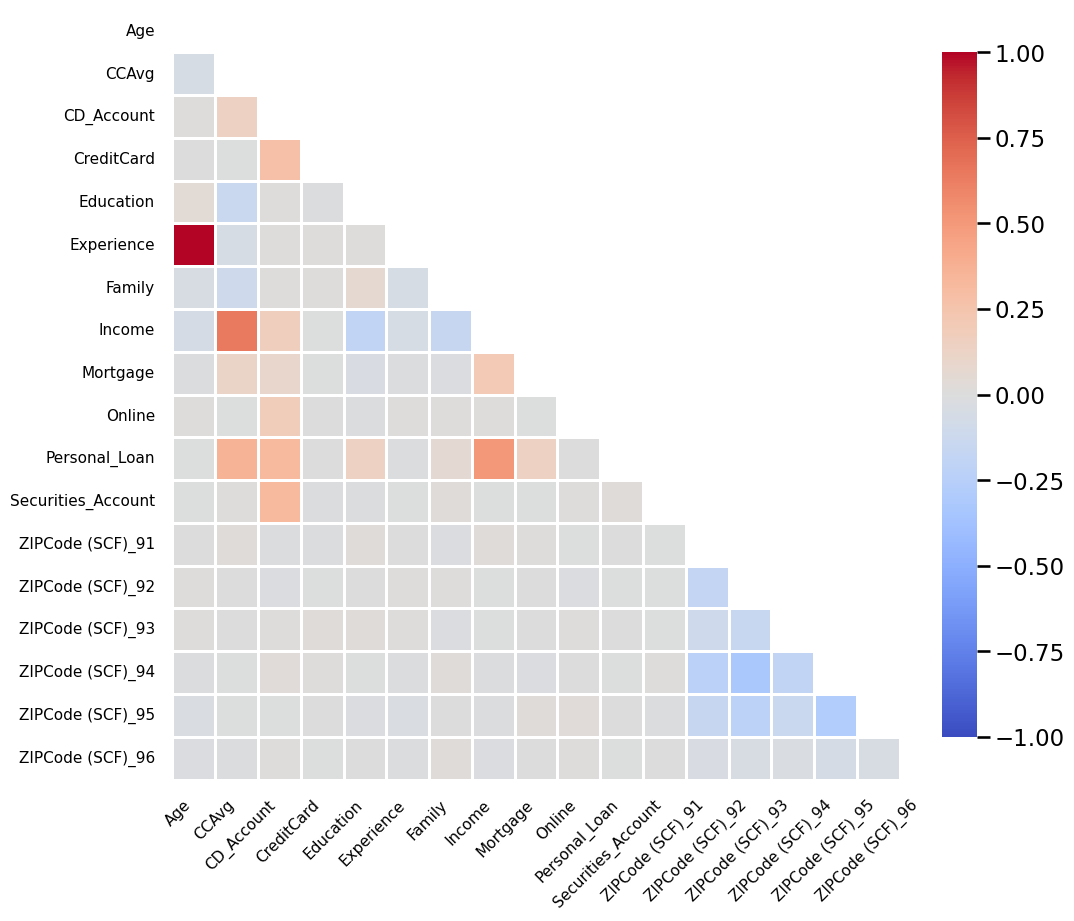

In [ ]:
mydf = df.copy()
drop_first = True
mydf = mydf.drop(['Mortgage > 0'], axis=1)
# mydf = mydf.drop(['Experience'], axis=1)
for col in ['Education', 'Family']:
  mydf[col] = mydf[col].astype('int')
mydf = pd.get_dummies(mydf, columns = ['ZIPCode (SCF)'], drop_first=drop_first)
mydf = mydf.astype(float)
corr = mydf.corr()
table_all = correlation_numeric_analysis(corr)
heatmap(corr, figsize=(18, 10), vmin = -1 , vmax = 1, corner = True,
        rotation_x = 45, rotation_y = 0, annot=False, to_rename=False,
        tick_fontsize = 11,
        name = f'all_columns{"_drop_first" if drop_first else ""}{"_keep_experience" if "Experience" in mydf.columns else ""}')
display(table_all[(table_all['Correlation'] > .2) | (table_all['Correlation'] < -.2)])

In [ ]:
def get_columns_to_drop(df, thresh = 0.85):
    corr = df.corr(numeric_only=True)
    table = correlation_numeric_analysis(corr)
    table = table[table['Correlation']>thresh]
    print('Highly correlated columns to drop:')
    out1 = []
    out2 = []
    for i, row in table.iterrows():
      out1.append(row['Variable 2'])
      out2.append(row['Variable 1'])
      print(f"Drop either \'{row['Variable 2']}\' or \'{row['Variable 1']}\' (corr: {row['Correlation']:.2f})")
    print(f'{out1} or {out2}')

def get_columns_for_dummy_variables(X):
  nunique = X.nunique()
  category_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
  possible_category_cols = list(set(nunique[nunique <10].index.tolist() + category_cols))
  binary_cols = nunique[nunique == 2].index.tolist()
  binary_cols_0_1  = [c for c in binary_cols if X[c].sort_values().unique().tolist() == [0, 1]]
  category_cols_non_0_1_binary = [c for c in possible_category_cols if c not in binary_cols_0_1]
  print(f'Columns to consider using in\n\tX = pd.get_dummies(X, columns={category_cols_non_0_1_binary}, drop_first=True)')


def get_percentage_of_classes(y, name):
  proportion = 100*y.value_counts(normalize=True).round(2)
  proportion = proportion.apply(lambda x: f'{x:.0f}%')
  proportion.name = name
  return proportion


def check_if_train_test_balanced(X_train, X_test, y_train, y_test):
  print(f"Shape of Training set : {X_train.shape[0]:,}, {X_train.shape[1]}")
  print(f"Shape of Test set : {X_test.shape[0]:,}, {X_test.shape[1]}")

  prop_train = get_percentage_of_classes(y_train, 'Percentage (training)')
  prop_test = get_percentage_of_classes(y_test, 'Percentage (test)')
  display(pd.concat([prop_train, prop_test], axis=1))

In [ ]:
get_columns_to_drop(df)
to_drop_cols = ['Experience', 'Mortgage > 0']
target = 'Personal_Loan'

Highly correlated columns to drop:
Drop either 'Mortgage > 0' or 'Mortgage' (corr: 1.00)
Drop either 'Experience' or 'Age' (corr: 0.99)
['Mortgage > 0', 'Experience'] or ['Mortgage', 'Age']


In [ ]:
X = df.drop([target]+to_drop_cols, axis=1)
Y = df[target]
get_columns_for_dummy_variables(X)
X_columns = X.columns.tolist()
X = pd.get_dummies(X, columns=['Education', 'Family', 'ZIPCode (SCF)'], drop_first=False)
X = X.astype(float)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)

check_if_train_test_balanced(X_train, X_test, y_train, y_test)


if to_stratify:
  # Splitting data in train and test sets
  X_train, X_test, y_train, y_test = train_test_split(
      X, Y, test_size=0.30, random_state=1, stratify=Y
  )

  print('Stratified')
  check_if_train_test_balanced(X_train, X_test, y_train, y_test)

Columns to consider using in
	X = pd.get_dummies(X, columns=['ZIPCode (SCF)', 'Family', 'Education'], drop_first=True)
Shape of Training set : 3,500, 22
Shape of Test set : 1,500, 22


,Percentage (training),Percentage (test)
Personal_Loan,,
0,91%,90%
1,9%,10%


In [ ]:
def get_weighted_impurity(model):
  # Get necessary attributes from the decision tree
  impurity = model.tree_.impurity  # Impurity at each node
  node_samples = model.tree_.n_node_samples  # Number of samples at each node
  total_samples = node_samples[0]  # Total number of samples (at the root node)

  # Calculate overall impurity
  overall_impurity = 0
  for i in range(model.tree_.node_count):
      # Only consider leaf nodes if required
      if model.tree_.children_left[i] == model.tree_.children_right[i]:  # Leaf node
        overall_impurity += (node_samples[i] / total_samples) * impurity[i]

  return overall_impurity



# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target, name='',
                                             table_name = 'Decision Tree Model', data_name=''):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score
    auc_score = roc_auc_score(target, pred)

    info = {}
    if data_name:
      info.update({"Data": data_name})


    info.update({"Accuracy": round(acc, 2), "Recall": round(recall, 2),
                                        "Precision": round(precision, 2), "F1": round(f1,2), "AUC": round(auc_score, 2)})

    depth = model.max_depth

    if depth == None:
      depth = model.get_depth()


    ccp_alpha = model.ccp_alpha

    class_weight = model.class_weight
    if type(class_weight)==dict:
      class_weight = f'{class_weight}'



    weighted_impurity = get_weighted_impurity(model)


    info.update({
        'Max Depth': depth,
        'Max Leaf Nodes': model.max_leaf_nodes,
        'Min Samples Split': model.min_samples_split,
        'Criterion': model.criterion,
        'alpha': ccp_alpha,
        'Class Weight': class_weight,
        'Impurity': weighted_impurity
        })

    if name == '':
      name = type(model).__name__


    index = [0]
    if name:
      index = [name]

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(info, index=index)


    df_perf.index.name = table_name

    return df_perf


def confusion_matrix_sklearn1(model, predictors, target, figsize=(6, 4),
                             rotation_x = 0, rotation_y=0, cmap='Blues', name='', test_or_train=''):

  # y_pred = model.predict(predictors)
  # cm = confusion_matrix(target, y_pred, labels=model.classes_)
  # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
  #                               display_labels=model.classes_)

  if rotation_x == 0:
    xticks_rotation = 'horizontal'
  else:
    xticks_rotation = 'vertical'

  fig, ax = plt.subplots(figsize=figsize)

  disp = ConfusionMatrixDisplay.from_estimator(
    model, predictors, target, cmap=cmap,
    labels=None,
    sample_weight=None,
    normalize=None,
    display_labels=None,
    include_values=True,
    xticks_rotation=xticks_rotation,
    values_format=None, ax=ax, colorbar=True, im_kw=None, text_kw=None)

  disp.plot()
  plt.title(f'Confusion Matrix\n{name}\n{test_or_train} Data')
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.tick_params(left=False, bottom=False)
  name_modified = name.replace('\n', '_')
  plt.savefig(f"{image_path}/confusion_matrix_alt_{name_modified}_{test_or_train}.png", bbox_inches='tight');



def confusion_matrix_sklearn(model, predictors, target, figsize=(6, 4),
                             rotation_x = 0, rotation_y=0, cmap='Blues', name='', test_or_train=''):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            [f"{item:,}"+ f"\n\n{item / cm.flatten().sum():.1%}"]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm, annot=labels, fmt="", square = True, cmap=cmap,
                     linewidth=2)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation_x, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=rotation_y)
    plt.title(f'Confusion Matrix\n{name}\n{test_or_train} Data')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tick_params(left=False, bottom=False)
    name_modified = name.replace('\n', '_')
    plt.savefig(f"{image_path}/confusion_matrix_{name_modified}_{test_or_train}.png", bbox_inches='tight');

def visualize_tree(model, feature_names, class_names=None, figsize=(20, 30),
                   name='', fontsize=9, filled=True, rounded=True,
                   proportion = True):

  plt.figure(figsize=figsize)
  out = tree.plot_tree(
      model,
      feature_names=feature_names,
      filled=filled,
      fontsize=fontsize,
      rounded = rounded,
      node_ids=False,
      proportion=proportion,
      class_names=class_names,
  )
  # below code will add arrows to the decision tree split if they are missing
  for o in out:
      arrow = o.arrow_patch
      if arrow is not None:
          arrow.set_edgecolor("black")
          arrow.set_linewidth(1)
  plt.title(f"Decision Tree for {name} Model")  # Add a title
  plt.savefig(f"{image_path}/tree_{name}.png", bbox_inches='tight');

def export_tree_text(model, feature_names, name=''):

  # Text report showing the rules of a decision tree -

  tree_text = tree.export_text(model, feature_names=feature_names, show_weights=True)


  # Save the text to a file
  file_path = f"tree_text/decision_tree_{name}.txt"  # Specify your file name
  with open(file_path, "w") as f:
      f.write(tree_text)

  print(f"Decision tree structure saved to {file_path}")

  return tree_text



In [ ]:
def plot_feature_importance(model, feature_names, figsize=(4, 8),
                            color = 'skyblue',
                            alpha = 0.6,
                            name=''):
  """
  Importance of features in the tree building.
  (The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature.
  It is also known as the Gini importance.)
  """


  importances = model.feature_importances_
  indices = np.argsort(importances)

  importance_df = (
      pd.DataFrame(
          importances, columns=["Importance"], index=feature_names
      ).sort_values(by="Importance", ascending=False)
  )
  importance_df.index.name = "Feature"

  display(importance_df)

  plt.figure(figsize=figsize)

  # yticks = range(len(indices))
  # ylabels = [feature_names[i] for i in indices]
  # plt.barh(yticks, importances[indices], color=color, align="center")
  # plt.yticks(ticks=yticks, labels=ylabels)

  sns.barplot(y=feature_names, x=importances, color=color, alpha=alpha,
              order=importance_df.sort_values(by="Importance", ascending=False).index)

  plt.xlabel("Relative Importance")
  plt.ylabel("Features", rotation=90)
  sns.despine(top = True, right = True)
  # plt.title(f"Feature Importances\n{name} Decision Tree Model")
  plt.title(f"Feature Importances\n{name}")
  plt.savefig(f"{image_path}/feature_importances_{name}.png", bbox_inches='tight');

### Decision Tree (sklearn default)

In [ ]:
model = DecisionTreeClassifier(criterion="gini", random_state=1)
model.fit(X_train, y_train)
models = {k: {'Default': model} for k in scoring_methods}

In [ ]:
#!mkdir -p tree_text

In [ ]:
def get_estimator(X_train, y_train, X_test, y_test,
                  max_depth, max_leaf_nodes, min_samples_split,
                  criterion = 'gini',
                  class_weight = None,
                  optimize_on = 'Recall',
                  random_state=42):
    if min_samples_split == None:
      min_samples_split = 2
    # Initialize the tree with the current set of parameters
    estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_split=min_samples_split,
        class_weight=class_weight,
        criterion=criterion,
        random_state=random_state
    )

    # Fit the model to the training data
    estimator.fit(X_train, y_train)

    # Make predictions on the training and test sets
    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)

    # Calculate recall scores for training and test sets
    if optimize_on == 'Recall':
      score_method = recall_score
    elif optimize_on == 'F1':
      score_method = f1_score
    elif optimize_on == 'Precision':
      score_method = precision_score
    elif optimize_on == 'Accuracy':
      score_method = accuracy_score
    else:
      raise ValueError('optimize_on must be one of Recall, F1, Precision, Accuracy')

    train_score = score_method(y_train, y_train_pred)
    test_score = score_method(y_test, y_test_pred)

    # Calculate the absolute difference between training and test recall scores
    score_diff = abs(train_score - test_score)


    name = f'{criterion} {max_depth} {max_leaf_nodes} {min_samples_split}'
    if class_weight:
      name += f' {estimator.class_weight}'

    perf_train = model_performance_classification_sklearn(
        estimator, X_train, y_train, name=name, data_name='Train'
    )

    perf_test = model_performance_classification_sklearn(
        estimator, X_test, y_test, name=name, data_name='Test'
    )

    return estimator, score_diff, perf_train, perf_test

In [ ]:
given_class_weight_0 = y_train.value_counts(normalize=True).round(3).to_dict()
given_class_weight_0
k1, k2 = list(given_class_weight_0.keys())
reverse_map = {k1: k2, k2: k1}
given_class_weight = {reverse_map[k]: v for k, v in given_class_weight_0.items()}
given_class_weight

{1: 0.905, 0: 0.095}

In [ ]:
estimator, score_diff, perf_train, perf_test = get_estimator(X_train, y_train, X_test, y_test, 2, 20, 2, 'entropy', 'balanced')
display(pd.concat([perf_train, perf_test], axis=0))

estimator, score_diff, perf_train, perf_test = get_estimator(X_train, y_train, X_test, y_test, 2, 20, 2, 'gini', 'balanced')
display(pd.concat([perf_train, perf_test], axis=0))

estimator, score_diff, perf_train, perf_test = get_estimator(X_train, y_train, X_test, y_test, 2, 20, 2, 'gini', given_class_weight)
display(pd.concat([perf_train, perf_test], axis=0))

estimator, score_diff, perf_train, perf_test = get_estimator(X_train, y_train, X_test, y_test, 2, 20, 2, 'gini', given_class_weight_0)
display(pd.concat([perf_train, perf_test], axis=0))

estimator, score_diff, perf_train, perf_test = get_estimator(X_train, y_train, X_test, y_test, 2, 20, 2, 'gini', {0:.5, 1:.5})
display(pd.concat([perf_train, perf_test], axis=0))

,Data,Accuracy,Recall,Precision,F1,AUC,Max Depth,Max Leaf Nodes,Min Samples Split,Criterion,alpha,Class Weight,Impurity
Decision Tree Model,,,,,,,,,,,,,
entropy 2 20 2 balanced,Train,0.79,1.0,0.31,0.47,0.88,2,20,2,entropy,0.0,balanced,0.224735
entropy 2 20 2 balanced,Test,0.78,1.0,0.31,0.47,0.88,2,20,2,entropy,0.0,balanced,0.224735


,Data,Accuracy,Recall,Precision,F1,AUC,Max Depth,Max Leaf Nodes,Min Samples Split,Criterion,alpha,Class Weight,Impurity
Decision Tree Model,,,,,,,,,,,,,
gini 2 20 2 balanced,Train,0.79,1.0,0.31,0.47,0.88,2,20,2,gini,0.0,balanced,0.107086
gini 2 20 2 balanced,Test,0.78,1.0,0.31,0.47,0.88,2,20,2,gini,0.0,balanced,0.107086


,Data,Accuracy,Recall,Precision,F1,AUC,Max Depth,Max Leaf Nodes,Min Samples Split,Criterion,alpha,Class Weight,Impurity
Decision Tree Model,,,,,,,,,,,,,
"gini 2 20 2 {1: 0.905, 0: 0.095}",Train,0.79,1.0,0.31,0.47,0.88,2,20,2,gini,0.0,"{1: 0.905, 0: 0.095}",0.107162
"gini 2 20 2 {1: 0.905, 0: 0.095}",Test,0.78,1.0,0.31,0.47,0.88,2,20,2,gini,0.0,"{1: 0.905, 0: 0.095}",0.107162


,Data,Accuracy,Recall,Precision,F1,AUC,Max Depth,Max Leaf Nodes,Min Samples Split,Criterion,alpha,Class Weight,Impurity
Decision Tree Model,,,,,,,,,,,,,
"gini 2 20 2 {0: 0.905, 1: 0.095}",Train,0.97,0.63,1.0,0.78,0.82,2,20,2,gini,0.0,"{0: 0.905, 1: 0.095}",0.008457
"gini 2 20 2 {0: 0.905, 1: 0.095}",Test,0.96,0.58,1.0,0.74,0.79,2,20,2,gini,0.0,"{0: 0.905, 1: 0.095}",0.008457


,Data,Accuracy,Recall,Precision,F1,AUC,Max Depth,Max Leaf Nodes,Min Samples Split,Criterion,alpha,Class Weight,Impurity
Decision Tree Model,,,,,,,,,,,,,
"gini 2 20 2 {0: 0.5, 1: 0.5}",Train,0.97,0.67,1.0,0.80,0.84,2,20,2,gini,0.0,"{0: 0.5, 1: 0.5}",0.052053
"gini 2 20 2 {0: 0.5, 1: 0.5}",Test,0.96,0.62,1.0,0.76,0.81,2,20,2,gini,0.0,"{0: 0.5, 1: 0.5}",0.052053


In [ ]:
e, score_diff, perf_train, perf_test = get_estimator(X_train, y_train, X_test, y_test, 2, 20, 2, 'gini', given_class_weight)
display(pd.concat([perf_train, perf_test], axis=0))

,Data,Accuracy,Recall,Precision,F1,AUC,Max Depth,Max Leaf Nodes,Min Samples Split,Criterion,alpha,Class Weight,Impurity
Decision Tree Model,,,,,,,,,,,,,
"gini 2 20 2 {1: 0.905, 0: 0.095}",Train,0.79,1.0,0.31,0.47,0.88,2,20,2,gini,0.0,"{1: 0.905, 0: 0.095}",0.107162
"gini 2 20 2 {1: 0.905, 0: 0.095}",Test,0.78,1.0,0.31,0.47,0.88,2,20,2,gini,0.0,"{1: 0.905, 0: 0.095}",0.107162


In [ ]:
def get_best_estimator_pre_prunning(X_train, y_train, X_test, y_test,
                                    max_depth_values = np.arange(2, 7, 2),
                                    max_leaf_nodes_values = [50, 75, 150, 250],
                                    min_samples_split_values = [10, 30, 50, 70],
                                    criterion_values = ['gini', 'entropy', 'log_loss'],
                                    class_weight_values = [None, 'balanced'],
                                    optimize_on='Recall', performance_all=pd.DataFrame()):

  # Initialize variables to store the best model and its performance
  best_estimator = None
  best_score_diff = float('inf')
  best_test_score = 0.0

  # Iterate over all combinations of the specified parameter values
  for criterion in criterion_values:
    for class_weight in class_weight_values:
      for max_depth in max_depth_values:
        for max_leaf_nodes in max_leaf_nodes_values:
            for min_samples_split in min_samples_split_values:

              # Train and evaluate the model with the current parameters

                estimator, score_diff, perf_train, perf_test = get_estimator(X_train, y_train, X_test, y_test,
                    max_depth, max_leaf_nodes, min_samples_split,
                                    optimize_on=optimize_on,
                                    class_weight=class_weight,
                                    criterion=criterion )
                performance_all = pd.concat([performance_all, perf_train, perf_test], axis=0)

                test_score = perf_test[optimize_on].values[0]
                train_score = perf_train[optimize_on].values[0]

                # Update the best estimator and best score if the current one has a smaller score difference
                if (score_diff < best_score_diff) & (test_score > best_test_score):
                    best_score_diff = score_diff
                    best_test_score = test_score
                    best_estimator = estimator

  # Print the best parameters
  print("Best parameters found:")
  print(f"\tMax depth: {best_estimator.max_depth}")
  print(f"\tMax leaf nodes: {best_estimator.max_leaf_nodes}")
  print(f"\tMin samples split: {best_estimator.min_samples_split}")
  print(f"\tBest test {optimize_on} score: {best_test_score:.4f}")
  perf_test = model_performance_classification_sklearn(
      best_estimator, X_test, y_test, name=f'Best {optimize_on}', data_name='Test'
  )
  perf_train = model_performance_classification_sklearn(
      best_estimator, X_train, y_train, name=f'Best {optimize_on}', data_name='Train'
  )

  performance_all = pd.concat([performance_all, perf_train, perf_test], axis=0)

  # Fit the best algorithm to the data.
  best_estimator.fit(X_train, y_train) ## Complete the code to fit model on train data

  return best_estimator, performance_all

In [ ]:
max_depth_values = [1, 2, 3, 4, 6, 8, 10, 15]
max_leaf_nodes_values = [50, 75, 150, 250]
min_samples_split_values = [10, 20, 30, 50, 70]
# class_weight_values = [None, 'balanced', given_class_weight, given_class_weight_0, {0: 0.5, 1: 0.5}]
class_weight_values = [None, 'balanced']

performance_all = pd.DataFrame()
for optimize_on in scoring_methods:
  best_estimator, performance_all = get_best_estimator_pre_prunning(X_train, y_train, X_test, y_test,
                                      max_depth_values = max_depth_values,
                                      max_leaf_nodes_values = max_leaf_nodes_values,
                                      min_samples_split_values = min_samples_split_values,
                                      class_weight_values = class_weight_values,
                                      optimize_on=optimize_on, performance_all=performance_all)

  models[optimize_on].update({'Pre-Pruned': best_estimator})

Best parameters found:
	Max depth: 6
	Max leaf nodes: 50
	Min samples split: 50
	Best test F1 score: 0.9100
Best parameters found:
	Max depth: 2
	Max leaf nodes: 50
	Min samples split: 10
	Best test Recall score: 1.0000
Best parameters found:
	Max depth: 2
	Max leaf nodes: 50
	Min samples split: 10
	Best test Precision score: 1.0000
Best parameters found:
	Max depth: 2
	Max leaf nodes: 50
	Min samples split: 10
	Best test Accuracy score: 0.9500


In [ ]:
print(performance_all.shape)
performance_all.drop_duplicates(inplace=True)
print(performance_all.shape)

(7688, 13)
(1920, 13)


In [ ]:
performance_all

,Data,Accuracy,Recall,Precision,F1,AUC,Max Depth,Max Leaf Nodes,Min Samples Split,Criterion,alpha,Class Weight,Impurity
Decision Tree Model,,,,,,,,,,,,,
gini 1 50 10,Train,0.91,0.00,0.00,0.00,0.50,1,50,10,gini,0.0,None,0.124167
gini 1 50 10,Test,0.90,0.00,0.00,0.00,0.50,1,50,10,gini,0.0,None,0.124167
gini 1 50 20,Train,0.91,0.00,0.00,0.00,0.50,1,50,20,gini,0.0,None,0.124167
gini 1 50 20,Test,0.90,0.00,0.00,0.00,0.50,1,50,20,gini,0.0,None,0.124167
gini 1 50 30,Train,0.91,0.00,0.00,0.00,0.50,1,50,30,gini,0.0,None,0.124167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
log_loss 15 250 30 balanced,Test,0.97,0.95,0.80,0.87,0.96,15,250,30,log_loss,0.0,balanced,0.018590
log_loss 15 250 50 balanced,Train,0.97,0.99,0.76,0.86,0.98,15,250,50,log_loss,0.0,balanced,0.043010
log_loss 15 250 50 balanced,Test,0.96,0.96,0.75,0.84,0.96,15,250,50,log_loss,0.0,balanced,0.043010


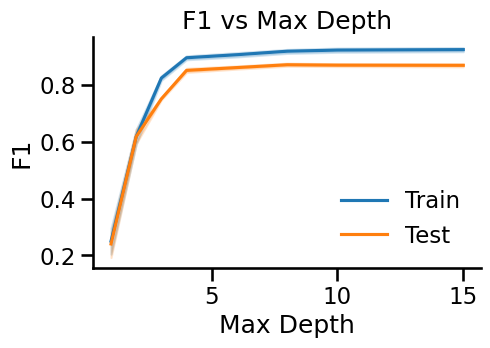

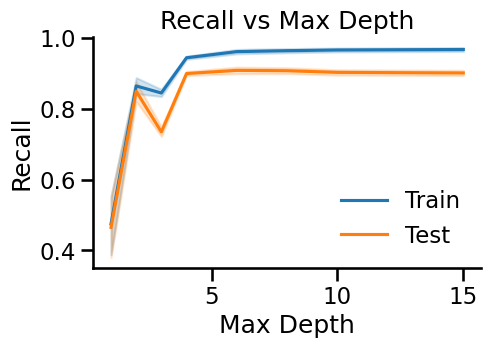

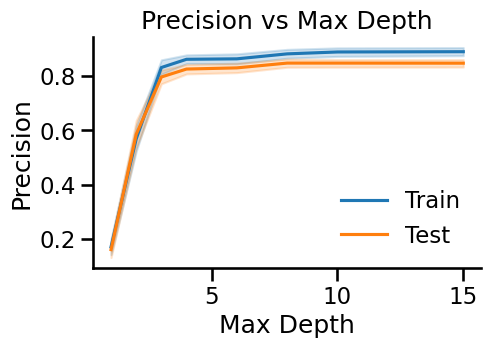

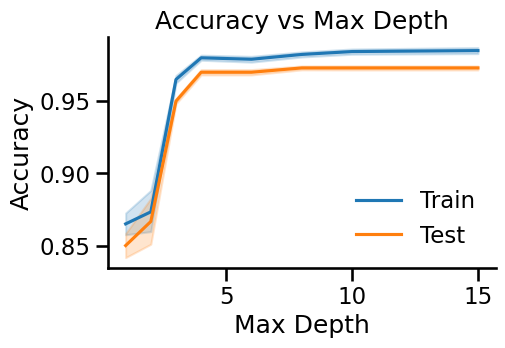

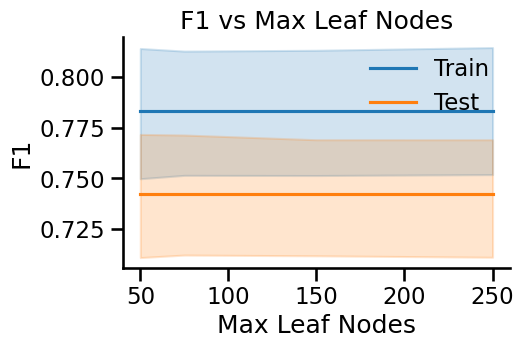

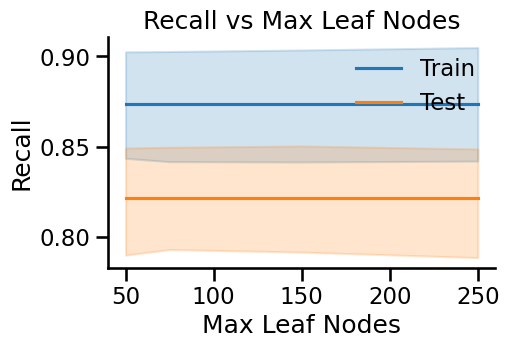

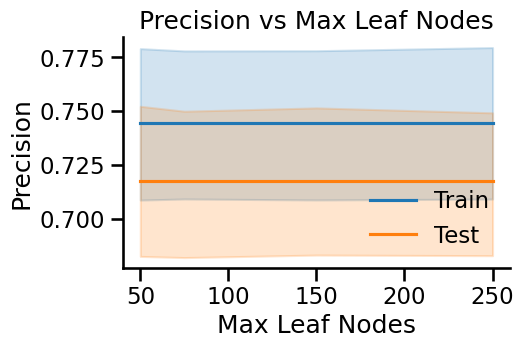

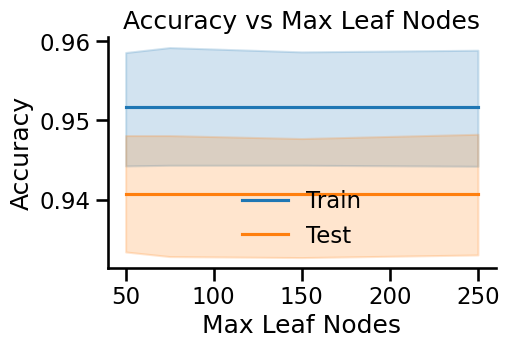

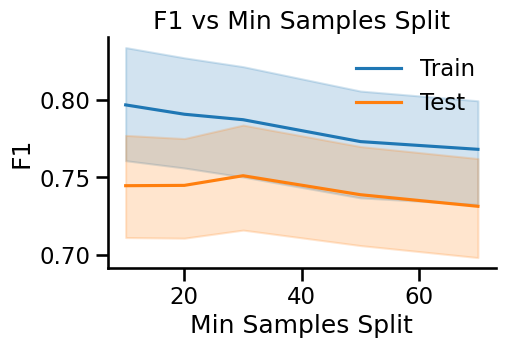

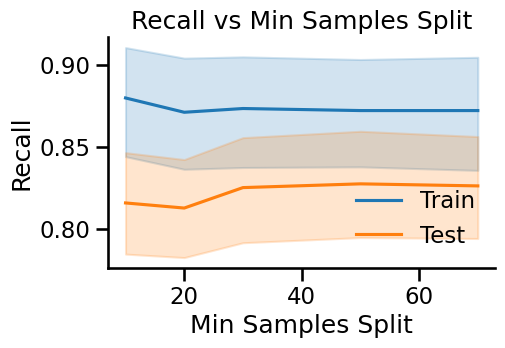

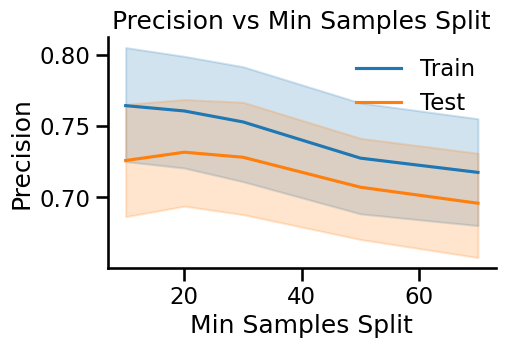

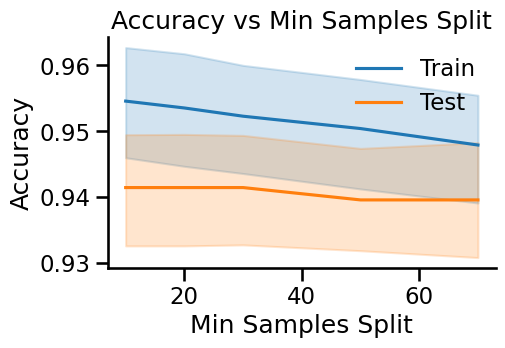

In [ ]:
for field in ['Max Depth', 'Max Leaf Nodes', 'Min Samples Split']:
  for optimize_on in scoring_methods:
    plt.figure(figsize=(5,3))
    sns.lineplot(data=performance_all, x=field, y=optimize_on, hue='Data');
    plt.legend(frameon = False)
    sns.despine(top=True, right=True)
    plt.title(f'{optimize_on} vs {field}')
    plt.savefig(f"{image_path}/{optimize_on}_vs_{field}.png", bbox_inches='tight');

https://scikit-learn.org/1.5/auto_examples/tree/plot_cost_complexity_pruning.html

In [ ]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas, impurities = path.ccp_alphas, path.impurities
path_df = pd.DataFrame(path)
path_df.drop_duplicates(subset=['ccp_alphas'], inplace = True)
ccp_alphas = path_df['ccp_alphas'].values
impurities = path_df['impurities'].values
display(path_df.head())

,ccp_alphas,impurities
0,0.000000,0.000000
1,0.000188,0.000564
2,0.000268,0.001637
3,0.000273,0.003274
4,0.000275,0.003824


In [ ]:
def plot_impurity_vs_alpha(impurities, ccp_alphas, figsize=(10, 5),
                           color='grey'):
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o",
          color = color, markerfacecolor="none",linewidth=1,
          drawstyle="steps-post")
  ax.set_xlabel(r"Effective $\alpha$")
  ax.set_ylabel("Total Impurity of Leaves")
  ax.set_title(r"Total Impurity vs Effective $\alpha$ for Training Set")
  sns.despine(top=True, right=True)
  plt.savefig(f"{image_path}/{optimize_on}_vs_{field}.png", bbox_inches='tight');

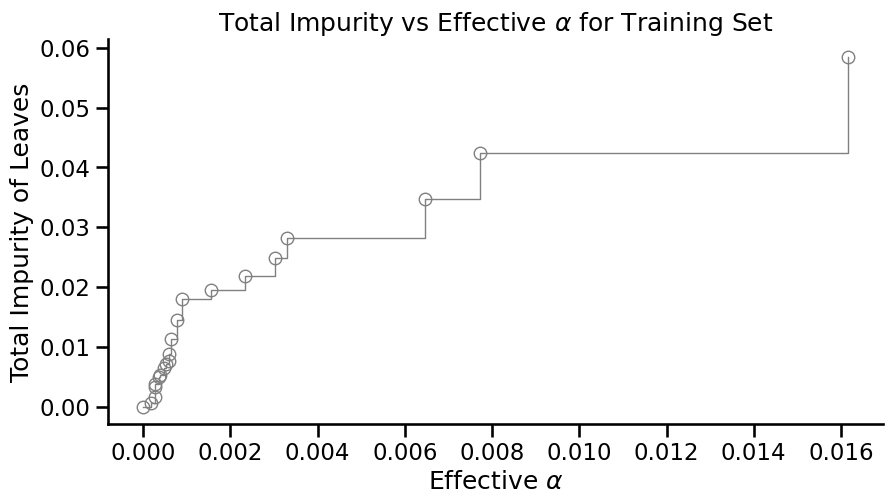

In [ ]:
plot_impurity_vs_alpha(impurities, ccp_alphas)

In [ ]:
pp_performance_all = pd.DataFrame()

clfs = []
for ind, ccp_alpha in enumerate(ccp_alphas):
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)     ## Complete the code to fit decision tree on training data
    clfs.append(clf)
    perf_train = model_performance_classification_sklearn(
        clf, X_train, y_train, name=f'{ind} a = {ccp_alpha:.3e} Train', data_name='Train'
    )

    perf_test = model_performance_classification_sklearn(
        clf, X_test, y_test, name=f'{ind} a = {ccp_alpha:.3e} Test', data_name='Test'
    )
    pp_performance_all = pd.concat([pp_performance_all, perf_train, perf_test], axis=0)
print(f"# Nodes in the last tree is: {clfs[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]:.4f}")

# Nodes in the last tree is: 1 with ccp_alpha: 0.0564


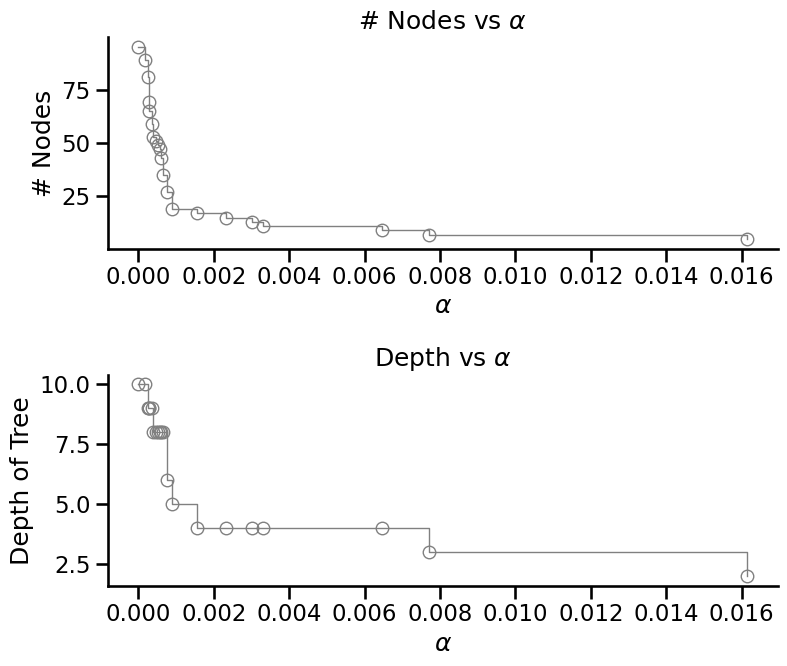

In [ ]:
def plot_num_nodes_depth_vs_alpha(clfs, ccp_alphas, figsize=(8, 7),
                                  color = 'grey'):
  node_counts = [clf.tree_.node_count for clf in clfs]
  depth = [clf.tree_.max_depth for clf in clfs]
  fig, ax = plt.subplots(2, 1, figsize=figsize, sharex='row')
  ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post",
          color = color, markerfacecolor='none', linewidth=1
          )
  ax[0].set_xlabel(r"$\alpha$")
  ax[0].set_ylabel("# Nodes")
  ax[0].set_title(r"# Nodes vs $\alpha$")
  sns.despine(top=True, right=True, ax=ax[0])
  ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post",
          color = color, markerfacecolor='none', linewidth=1
          )
  ax[1].set_xlabel(r"$\alpha$")
  ax[1].set_ylabel("Depth of Tree")
  ax[1].set_title(r"Depth vs $\alpha$")
  sns.despine(top=True, right=True, ax=ax[1])
  fig.tight_layout()
  plt.savefig(f"{image_path}/num_nodes_depth_vs_alpha.png", bbox_inches='tight');


plot_num_nodes_depth_vs_alpha(clfs[:-1], ccp_alphas[:-1])

In [ ]:
def plot_metric_vs_alpha(pp_performance_all, optimize_on, ccp_alphas, figsize=(8, 3)):
  fig, ax = plt.subplots(figsize=figsize)
  for data_name in ['Train', 'Test']:
    sub = pp_performance_all[pp_performance_all['Data'] == data_name]
    score = sub[optimize_on]
    if data_name == 'Test':
      index_best_model = np.argmax(score)
      best_model = clfs[index_best_model]

    ax.plot(ccp_alphas[:-1], score[:-1], marker="o", label=data_name,
            markerfacecolor='none', linewidth=1,
            drawstyle="steps-post")

  ax.set_xlabel(r"$\alpha$")
  ax.set_ylabel(optimize_on)
  ax.set_title(rf"{optimize_on} vs $\alpha$")
  ax.legend(frameon=False)
  sns.despine(top=True, right=True)
  plt.savefig(f"{image_path}/{optimize_on}_vs_alpha_post_prune.png", bbox_inches='tight');
  return best_model

In [ ]:
def post_pruned(X_train, y_train, X_test, y_test,
                optimize_on = 'Recall',
                random_state = 1, class_weight="balanced"):

  name = f"Post-Pruned Best {optimize_on}"
  clf = DecisionTreeClassifier(random_state=random_state,
                               class_weight=class_weight)
  path = clf.cost_complexity_pruning_path(X_train, y_train)
  ccp_alphas, impurities = abs(path.ccp_alphas), path.impurities

  clfs = []
  for ccp_alpha in ccp_alphas:
      clf = DecisionTreeClassifier(
          random_state=1, ccp_alpha=ccp_alpha, class_weight="balanced"
      )
      clf.fit(X_train, y_train)
      clfs.append(clf)

  clfs = clfs[:-1]
  ccp_alphas = ccp_alphas[:-1]

  node_counts = [clf.tree_.node_count for clf in clfs]
  depth = [clf.tree_.max_depth for clf in clfs]
  if optimize_on == 'Recall':
    score_method = recall_score
  elif optimize_on == 'F1':
    score_method = f1_score
  elif optimize_on == 'Precision':
    score_method = precision_score
  elif optimize_on == 'Accuracy':
    score_method = accuracy_score

  score_train = []
  for clf in clfs:
      pred_train = clf.predict(X_train)
      values_train = score_method(y_train, pred_train)
      score_train.append(values_train)

  score_test = []
  for clf in clfs:
      pred_test = clf.predict(X_test)
      values_test = score_method(y_test, pred_test)
      score_test.append(values_test)

  index_best_model = np.argmax(score_test)
  best_model = clfs[index_best_model]
  perf_train = model_performance_classification_sklearn(
      best_model, X_train, y_train, name=f'{name} Train', data_name='Train'
  )

  perf_test = model_performance_classification_sklearn(
      best_model, X_test, y_test, name=f'{name} Test', data_name='Test'
  )
  return best_model

for optimize_on in ['Accuracy', 'Recall', 'F1', 'Precision']:
  best_model = post_pruned(X_train, y_train, X_test, y_test, optimize_on = optimize_on)
  models[optimize_on].update({'Post-Pruned': best_model})

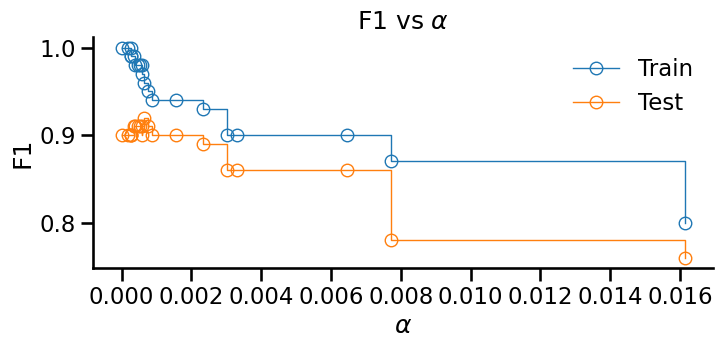

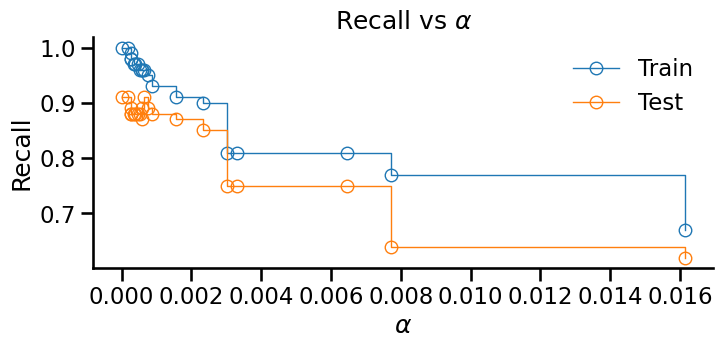

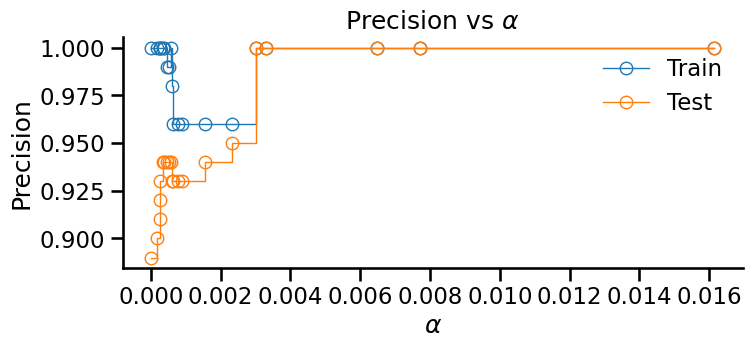

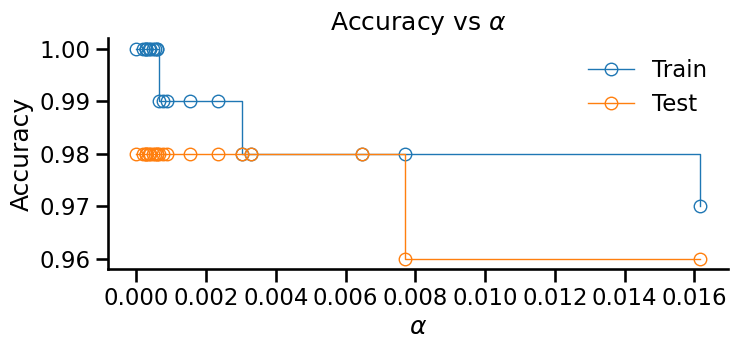

In [ ]:
for optimize_on in scoring_methods:
    best_model = plot_metric_vs_alpha(pp_performance_all, optimize_on, ccp_alphas)
    # models[optimize_on].update({'Post-Pruned': best_model})

In [ ]:
models.keys()

dict_keys(['F1', 'Recall', 'Precision', 'Accuracy'])

In [ ]:
models['Precision']

{'Default': DecisionTreeClassifier(random_state=1),
 'Pre-Pruned': DecisionTreeClassifier(max_depth=2, max_leaf_nodes=50, min_samples_split=10,
                        random_state=42),
 'Post-Pruned': DecisionTreeClassifier(class_weight='balanced', random_state=1)}

In [ ]:
perf_selected = {k : pd.DataFrame() for k in scoring_methods}

feature_names = list(X_train.columns)

for method, name_model in models.items():
  for name, model in name_model.items():
    name = f'({method}) {name}'
    confusion_matrix_sklearn(model, X_train, y_train, cmap = 'Greens', name=f'{name} Decision Tree Model',
                            test_or_train='Train')
    confusion_matrix_sklearn(model, X_test, y_test, cmap = 'Blues', name=f'{name} Decision Tree Model',
                            test_or_train='Test')

    perf_train = model_performance_classification_sklearn(
        model, X_train, y_train, name=name, data_name='Train'
    )

    perf_test = model_performance_classification_sklearn(
        model, X_test, y_test, name=name, data_name='Test'
    )
    perf_selected[method] = pd.concat([perf_selected[method], perf_train, perf_test], axis=0)


    visualize_tree(model, feature_names, class_names=None, figsize=(20, 30), name=name)
    tree_text = export_tree_text(model, feature_names, name=name)

    plot_feature_importance(model, feature_names, name=name)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
all_subs = {}
for method in scoring_methods:
  tab = perf_selected[method]
  # display(tab)
  selcols = ['Data','Accuracy', 'Recall', 'Precision', 'F1', 'AUC', 'Criterion', 'Max Depth', 'Max Leaf Nodes', 'Min Samples Split', 'Class Weight']
  # sub = tab[tab['Data']=='Test'][selcols]
  sub = tab[selcols]
  sub.index.name = 'Model'
  # sub.index.name = f'Model (Maximizing {method})'
  all_subs.update({method: sub})
  # display(sub)
# Combine tables with keys
combined = pd.concat(
    all_subs.values(),
    keys=all_subs.keys()
)

combined.index.names = ['Maximizing Score', 'Model']
# Display the combined table
display(combined)

Data  Accuracy  Recall  Precision  \
Maximizing Score Model                                                       
F1               Default                Train      1.00    1.00       1.00   
                 Default                 Test      0.98    0.91       0.89   
                 Pre-Pruned             Train      0.99    0.92       0.96   
                 Pre-Pruned              Test      0.98    0.87       0.94   
                 Post-Pruned            Train      1.00    1.00       0.95   
                 Post-Pruned             Test      0.98    0.89       0.88   
Recall           Default                Train      1.00    1.00       1.00   
                 Default                 Test      0.98    0.91       0.89   
                 Pre-Pruned             Train      0.79    1.00       0.31   
                 Pre-Pruned              Test      0.78    1.00       0.31   
                 Post-Pruned            Train      0.96    1.00       0.70   
                 Post-Pruned             Test      0.95    0.99       0.68   
Precision        Default                Train      1.00    1.00       1.00   
                 Default                 Test      0.98    0.91       0.89   
                 Pre-Pruned             Train      0.97    0.67       1.00   
                 Pre-Pruned              Test      0.96    0.62       1.00   
                 Post-Pruned            Train      1.00    1.00       1.00   
                 Post-Pruned             Test      0.98    0.86       0.90   
Accuracy         Default                Train      1.00    1.00       1.00   
                 Default                 Test      0.98    0.91       0.89   
                 Pre-Pruned             Train      0.95    0.76       0.74   
                 Pre-Pruned              Test      0.95    0.74       0.79   
                 Post-Pruned            Train      1.00    1.00       1.00   
                 Post-Pruned             Test      0.98    0.86       0.90   
                 (Selected) Pre-pruned  Train      0.99    0.92       0.96   
                 (Selected) Pre-pruned   Test      0.98    0.87       0.94   
                 (Selected) Pre-pruned  Train      0.99    0.92       0.96   
                 (Selected) Pre-pruned   Test      0.98    0.87       0.94   
                 (Selected) Pre-pruned  Train      0.99    0.92       0.96   
                 (Selected) Pre-pruned   Test      0.98    0.87       0.94   

                                          F1   AUC Criterion  Max Depth  \
Maximizing Score Model                                                    
F1               Default                1.00  1.00      gini         10   
                 Default                0.90  0.95      gini         10   
                 Pre-Pruned             0.94  0.96      gini          6   
                 Pre-Pruned             0.91  0.93      gini          6   
                 Post-Pruned            0.97  1.00      gini         13   
                 Post-Pruned            0.88  0.94      gini         13   
Recall           Default                1.00  1.00      gini         10   
                 Default                0.90  0.95      gini         10   
                 Pre-Pruned             0.47  0.88      gini          2   
                 Pre-Pruned             0.47  0.88      gini          2   
                 Post-Pruned            0.83  0.98      gini          6   
                 Post-Pruned            0.81  0.97      gini          6   
Precision        Default                1.00  1.00      gini         10   
                 Default                0.90  0.95      gini         10   
                 Pre-Pruned             0.80  0.84      gini          2   
                 Pre-Pruned             0.76  0.81      gini          2   
                 Post-Pruned            1.00  1.00      gini         15   
                 Post-Pruned            0.88  0.92      gini         15   
Accuracy         Default                1.00

Decision tree structure saved to tree_text/decision_tree_(Selected) Pre-pruned.txt


,Importance
Feature,
Education_1,0.446140
Income,0.331381
Family_3,0.104957
Family_4,0.054352
CCAvg,0.043728
CD_Account,0.015159
Age,0.003622
ZIPCode (SCF)_93,0.000661
ZIPCode (SCF)_95,0.000000


,Data,Accuracy,Recall,Precision,F1,Max Depth,Max Leaf Nodes,Min Samples Split,Criterion,alpha,Class Weight,Impurity
Decision Tree Model,,,,,,,,,,,,
(Selected) Pre-pruned,Train,0.99,0.92,0.96,0.94,6,50,50,gini,0.0,None,0.017346
(Selected) Pre-pruned,Test,0.98,0.87,0.94,0.91,6,50,50,gini,0.0,None,0.017346


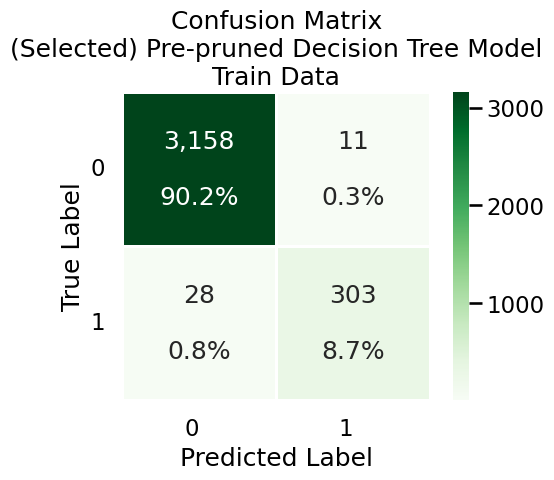

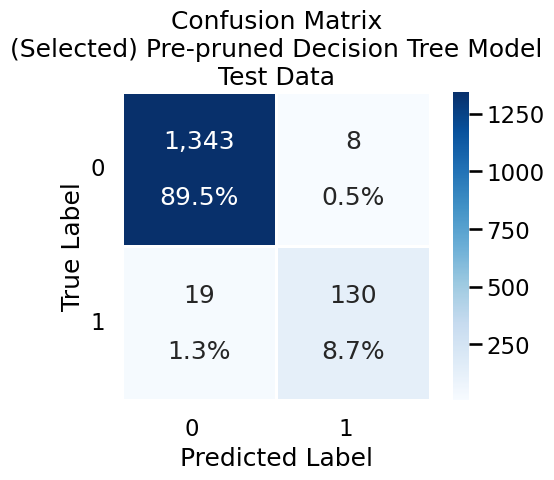

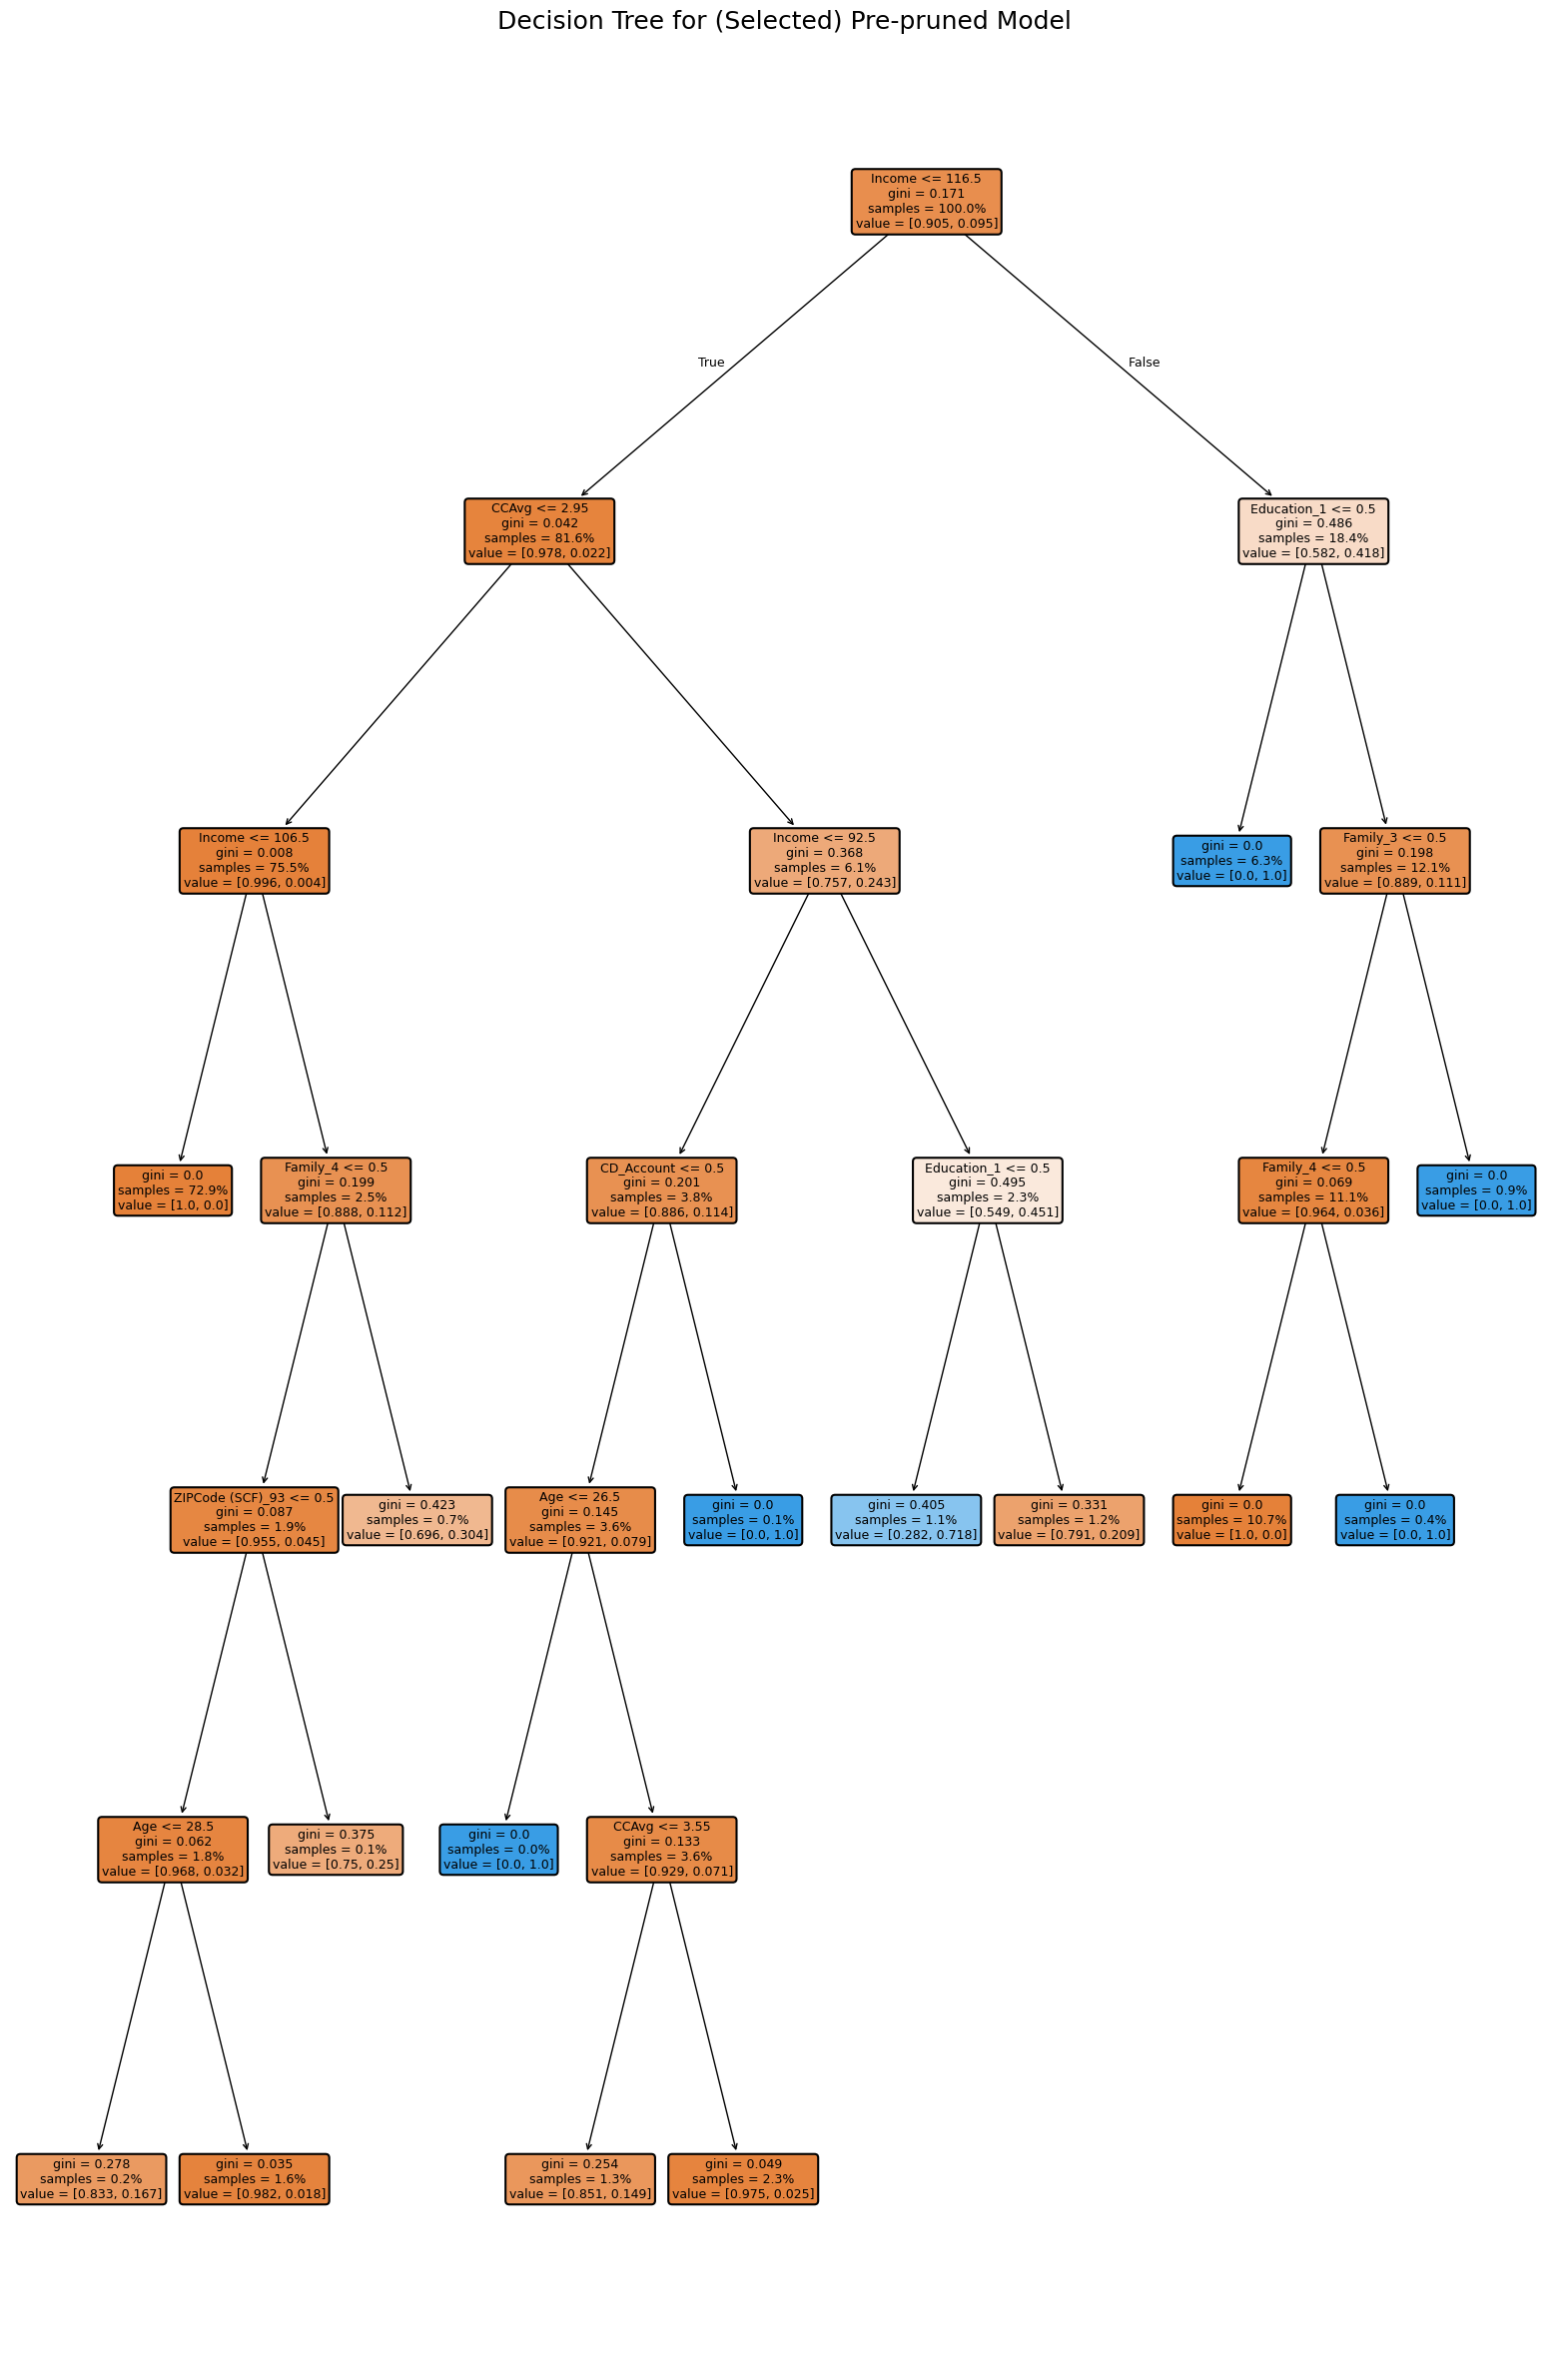

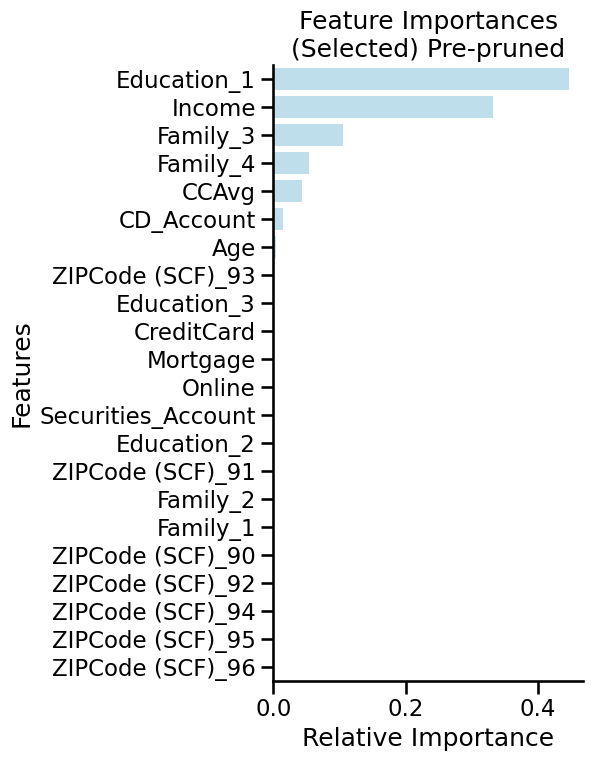

In [ ]:
selected_model = models['F1']['Pre-Pruned']
name = '(Selected) Pre-pruned'

confusion_matrix_sklearn(selected_model, X_train, y_train, cmap = 'Greens', name=f'{name} Decision Tree Model',
                            test_or_train='Train')
confusion_matrix_sklearn(selected_model, X_test, y_test, cmap = 'Blues', name=f'{name} Decision Tree Model',
                        test_or_train='Test')

perf_train = model_performance_classification_sklearn(
    selected_model, X_train, y_train, name=name, data_name='Train'
)

perf_test = model_performance_classification_sklearn(
    selected_model, X_test, y_test, name=name, data_name='Test'
)
perf_selected[method] = pd.concat([perf_selected[method], perf_train, perf_test], axis=0)


visualize_tree(selected_model, feature_names, class_names=None, figsize=(20, 30), name=name)
tree_text = export_tree_text(selected_model, feature_names, name=name)

plot_feature_importance(selected_model, feature_names, name=name)
display(pd.concat([perf_train, perf_test], axis=0).drop(columns=['AUC']))

In [ ]:
def plot_PR_curve(name_models, optimize_on, X_test, y_test, figsize=(5,5)):
  # Plot the Precision-Recall curve
  plt.figure(figsize=figsize)

  for name, model in name_models.items():
    # Predicted probabilities
    y_scores = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

    # Calculate the average precision score (AUC for PR curve)
    auc_pr = average_precision_score(y_test, y_scores)
    # auc_pr = auc(recall, precision)


    plt.plot(recall, precision, label=f'{name} (AUC = {auc_pr:.2f})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'Precision-Recall Curve\n(Maximizing {optimize_on})')
  plt.legend(frameon=False, bbox_to_anchor=(1.05, 1))
  sns.despine(top=True, right=True)
  plt.grid(linewidth=.5, linestyle=':')
  plt.savefig(f"{image_path}/PR_{optimize_on}.png", bbox_inches='tight');


In [ ]:
model = selected_model

y_scores = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred = model.predict(X_test)

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate the average precision score (AUC for PR curve)
auc_pr = average_precision_score(y_test, y_scores)
print(auc_pr)
pr_auc = auc(recall, precision)
print(roc_auc_score(y_test, y_pred))

0.949471185229595
0.9332808409381069


In [ ]:
auc_pr

0.6330870480862429

In [ ]:
pr_auc

0.771924016831876

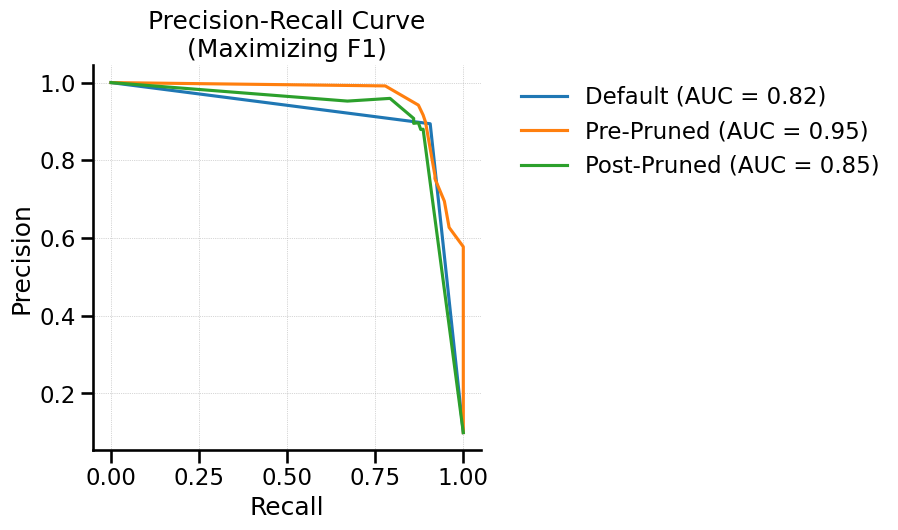

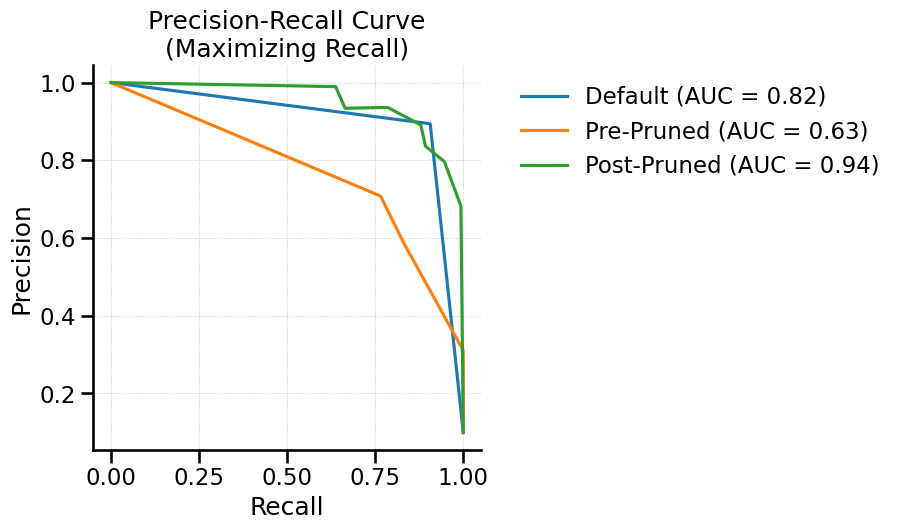

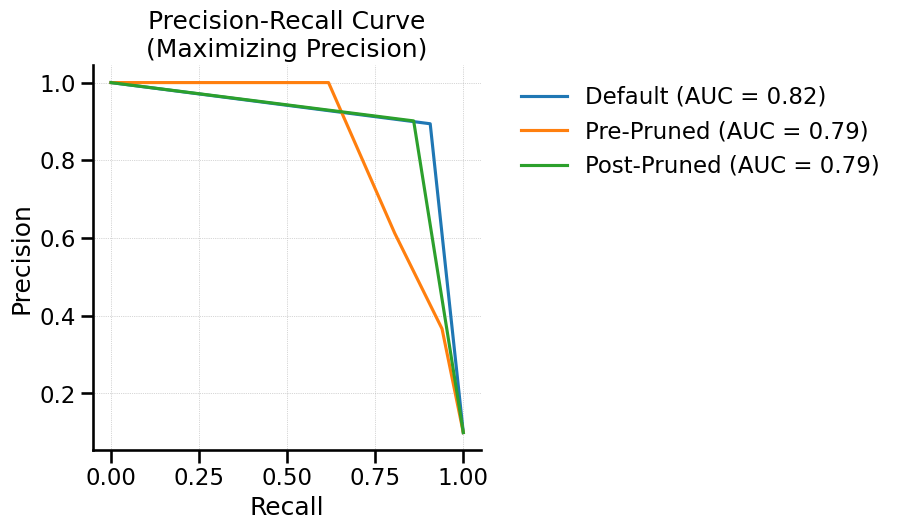

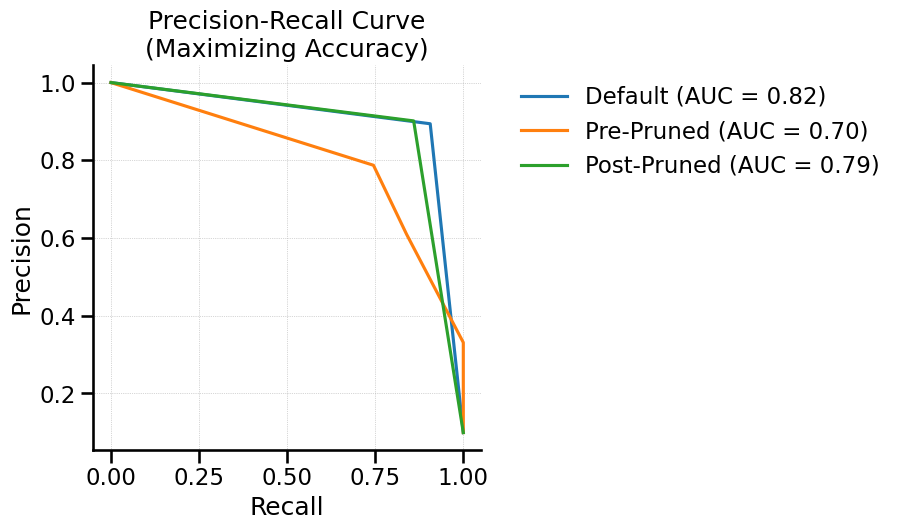

In [ ]:
for optimize_on in scoring_methods:
  plot_PR_curve(models[optimize_on], optimize_on, X_test, y_test)